In [11]:
from sklearn.metrics import confusion_matrix
# from openai import OpenAI
from src.data_paths import *
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import re
import spacy
from collections import Counter
from bs4 import BeautifulSoup
import seaborn as sns

class ToxicityAnalysis:
    def __init__(self):
        self.df, self.cancer_df = self.load_dataset()
        self.grouped_df, self.grouped_df_studied = self.filter_and_group_datasets()

        self.toxicity_related_frequent_words, self.high_severity, self.low_severity = self.find_different_severity_keywords()
        self.find_different_severity_keywords()
        self.add_toxicity_scores()
    
    def load_dataset(self):
        ### Load datasets

        df = pd.read_pickle(MERGED)
        cancer_df = pd.read_pickle(LIGANDS_RELATED_TO_PROTEIN)
        return df, cancer_df
    
    def filter_and_group_datasets(self):

        ### Keep only the ones matched with Drugbank to have the toxicity reports
        df_matched = self.df[self.df['Matched_On'].isna() == False]
        cancer_df_matched = self.cancer_df[self.cancer_df['Matched_On'].isna() == False]

        ### Find the drugs linked to our 11 most studied cancer related proteins
        highly_studied_proteins = [
            'Cytochrome P450 3A4', 'Epidermal growth factor receptor', 'Proto-oncogene tyrosine-protein kinase Src', 
            'Vascular endothelial growth factor receptor 2', 'Adenosine receptor A2a', 'Cytochrome P450 2C9', 
            'Cytochrome P450 1A2', 'Cytochrome P450 2C19', 'Cytochrome P450 2D6', 'Prostaglandin G/H synthase 1', 
            'Prostaglandin G/H synthase 2'
            ]
        
        pattern_highly_studied =  '|'.join(rf"\b{re.escape(term)}\b" for term in highly_studied_proteins)

        filtered_df_highly_studied = df_matched[df_matched['target_name'].str.contains(pattern_highly_studied, case=False, na=False)]
        filtered_df_highly_studied.reset_index(inplace=True)

        cancer_most_studied_drugs = filtered_df_highly_studied.drugbank_drug_name.unique()

        # rows from df_matched that have a drugbank_drug_name that is in cancer_most_studied_drugs
        cancer_most_studied_df = df_matched[df_matched['drugbank_drug_name'].isin(cancer_most_studied_drugs)]
        cancer_most_studied_df.reset_index(inplace=True)

        return self._groupping_by_drug(df_matched, cancer_most_studied_df)

    def _groupping_by_drug(self, df_matched, cancer_most_studied_df):
        
        ### Group by drug name and count the number of proteins
        agg_function_all = {
            "drugbank_drug_name": "count",
            "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
            "drugbank_drug_toxicity": "unique",
            "inchi_key": "unique",
            "ligand_name": "unique"
        }
        grouped_df = df_matched.groupby("drugbank_drug_name").agg(agg_function_all).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

        grouped_df["num_prot_per_drug"] = grouped_df["inchi_key"].apply(lambda x: len(x))
        grouped_df["num_lig_per_drug"] = grouped_df["ligand_name"].apply(lambda x: len(x))
        grouped_df["unique_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: x[0] )
        grouped_df["num_diff_toxicity"] = grouped_df["drugbank_drug_toxicity"].apply(lambda x: len(x) )

        ### Same, but only for studied drugs
        agg_function_studied = {
            "drugbank_drug_name": "count",
            "drugbank_drug_patent_approved": lambda x: x.notna().sum(),
            "drugbank_drug_toxicity": lambda x: x.unique(),
            "inchi_key" : lambda x: x.unique(),
            "ligand_name" : lambda x: x.unique()
        }
        grouped_df_studied = cancer_most_studied_df.groupby("drugbank_drug_name").agg(agg_function_studied).rename(columns={"drugbank_drug_name": "count"}).sort_values(by="count", ascending=False)

        grouped_df_studied["num_prot_per_drug"] = grouped_df_studied["inchi_key"].apply(lambda x: len(x))
        grouped_df_studied["num_lig_per_drug"] = grouped_df_studied["ligand_name"].apply(lambda x: len(x))

        grouped_df_studied["unique_toxicity"] = grouped_df_studied["drugbank_drug_toxicity"].apply(lambda x: x[0] )
        grouped_df_studied["num_diff_toxicity"] = grouped_df_studied["drugbank_drug_toxicity"].apply(lambda x: len(x) )
        return grouped_df, grouped_df_studied

    ## If we want to justify how we chose the toxicity related keywords
    def _get_most_common_toxicity(self):
 
        ## Get the unique toxicity values
        unique_toxicity_values = " ".join(self.grouped_df["unique_toxicity"].unique().astype(str))
        nlp = spacy.load('en_core_web_sm')
        doc = nlp(unique_toxicity_values)

        ## Remove stop words and punctuation
        words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

        ## Count the frequency of each word
        word_freq = Counter(words)
        common_words = word_freq.most_common(1000000)
        return common_words

    def find_different_severity_keywords(self):
        
        ### Manually checked toxicity related keywords
        toxicity_related_frequent_words = ["adverse",'toxicity','LD50','nausea','vomiting','renal','hypotension','severe',
                                    'pain','fetal','pregnancy','reactions','fertility','blood','cardiac',"overdosage",'respiratory'
                                    ,'symptomatic','diarrhea','acute','headache','gastrointestinal','depression',"dizziness","coma",
                                    'liver','failure','mutagenic','acid','heart','abdominal','bradycardia','impairment','convulsions',
                                    'hypertension','anemia','anaphylactic','anaphylaxis','arrhythmias','arrhythmia','asthma','bronchospasm',
                                    'bronchial','cancer','carcinogenic','carcinogenicity','cardiotoxicity','cardiovascular','gastric',
                                    'seizures','confusion','hepatic',"carcinogenicity",'death','rash','mutation','arrhythmias',
                                    "overdose","patients", "effects","adverse","toxicity","symptoms","nausea","vomiting","treatment",
                                    "renal","hypotension","pregnancy","severe","pain","fetal","reactions","fertility","cardiac","diarrhea",
                                    "headache","gastrointestinal","depression","dizziness","coma","respiratory","symptomatic","acne",
                                    "liver","failure","drowsiness","seizures","muscle","maternal","gastric","hypertension","death",
                                    "rash","bladder","edema","children","weakness","insomnia","syndrome","anemia","tumors","acidosis",
                                    "impaired","infant","pediatric","hallucinations","nervous","irritation","fever","constipation",
                                    "adenomas","birth","gestation","developmental","prolonged","mutagenicity","lethal","fatigue",
                                    "sedation","thrombocytopenia","bradycardia","tachycardia","convulsions","arrhythmias","CNS","somnolence",
                                    "hemodialysis","breast","acne","hepatotoxicity","pulmonary","malformations","thrombocytopenia",
                                    "lactation","ventricular","sweating","atropine","kidney","hepatotoxicity","restlessness",
                                    "seizure","emesis","adrenal","carcinomas","neutropenia","allergy","toxicity","arrhythmias","hypertension"]

        ### High severity keywords
        high_severity = ["cancer","coma","severe","overdose","death","lethal","serious","life-threatening","life threatening","strokes","fatal","mortality"]
        
        ### Low severity keywords
        toxicity_related_frequent_words = np.unique(toxicity_related_frequent_words)
        low_severity = [word for word in toxicity_related_frequent_words if word not in high_severity]

        return toxicity_related_frequent_words, high_severity, low_severity


    ###
    # The toxicity score is made from adding the score from a possible LD50 value, 
    # and weighted number of severity/toxicity/... related words. 
    # This score is then normalized by the word length of the toxicity report.
    def add_toxicity_scores(self):

        ### Assign a toxicity score to each drug based on the toxicity reports
        self.grouped_df["toxicity_score"] =  self.grouped_df["unique_toxicity"].apply(lambda x: (sum(3 for word in self.high_severity if word in str(x)) + sum(1 for word in self.low_severity if word in str(x)) + int(self._assign_severity_score(self._parse_lowest_ld50(str(x))))) )
        self.grouped_df["toxicity_score"] =  self.grouped_df["toxicity_score"]/self.grouped_df["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)

        ### Same, but only for studied drugs
        self.grouped_df_studied["toxicity_score"] =  self.grouped_df_studied["unique_toxicity"].apply(lambda x: (sum(3 for word in self.high_severity if word in str(x)) + sum(1 for word in self.low_severity if word in str(x)) + (self._assign_severity_score(self._parse_lowest_ld50(str(x))))) )
        self.grouped_df_studied["toxicity_score"] =  self.grouped_df_studied["toxicity_score"]/self.grouped_df_studied["unique_toxicity"].apply(lambda x: len(str(x).split()) if len(str(x).split()) != 0 else 0)

        ### With only non-empty toxicity scores
        self.grouped_df_tox = self.grouped_df.loc[self.grouped_df["unique_toxicity"].isna() == False]
        self.grouped_df_studied_tox = self.grouped_df_studied.loc[self.grouped_df_studied["unique_toxicity"].isna() == False]
        

    ### Parse the different toxicity reports and find the lowest LD50 value 
    def _parse_lowest_ld50(self,report):

        clean_report = BeautifulSoup(report, "html.parser").get_text()

        ## Find the LD50 values with custom regex
        matches = re.findall(r"LD50[^\d]*(\d+)\s*mg/kg", clean_report, re.IGNORECASE)
        if matches:
            ## Convert matches to int and find the minimum
            ld50_values = list(map(int, matches))
            return int(min(ld50_values))
        ## Nothing found
        return 0 


    ### We assign a severity score to each drug based on LD50 value. This is done by emperical observation
    def _assign_severity_score(self,ld50):
        if ld50 is None:
            return 0 
        if ld50 < 5000 and ld50 > 0:
            return max(5 - ld50/5000,0)
        else :
            return 0
    
    ### Plot the distribution of toxicity scores
    def plot_toxicity_scores(self):
        sns.histplot(self.grouped_df_tox["toxicity_score"], bins=50)
        sns.histplot(self.grouped_df_studied_tox["toxicity_score"], bins=50,color="red")

        plt.yscale("log")
        plt.xlabel("Toxicity")
        plt.title("Histogram of Toxicity Scores")
        plt.legend(["All Drugs", "Drugs Tested on the 11 Most\nStudied Cancer-related Proteins"])

        plt.show()
    
    ### Plot the number of entries per drug vs toxicity score
    def plot_toxicity_vs_proteins(self):
        
        ### Checking if the count column is present after renameing
        if 'count' not in self.grouped_df_tox.columns or 'count' not in self.grouped_df_studied_tox.columns:
            print("Count column missing in the data. Please check the data preparation steps.")
            return

        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=self.grouped_df_tox, x="toxicity_score", y="count", alpha=0.1)
        sns.scatterplot(data=self.grouped_df_studied_tox, x="toxicity_score", y="count", alpha=0.4, color="red")

        plt.xlabel("Toxicity Score")
        plt.ylabel("Number of ligand-protein pairs measured")
        plt.title("Amount of Research vs Toxicity Score")
        plt.legend(["All Drugs", "Drugs Tested on the 11 Most\nStudied Cancer-related Proteins"])
        plt.show()

    

In [12]:
toxicity_analysis = ToxicityAnalysis()

/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_68066/892806283.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()
/var/folders/_h/sv2httr97w1d8pv18rsdrqhc0000gn/T/ipykernel_68066/892806283.py:161: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_report = BeautifulSoup(report, "html.parser").get_text()


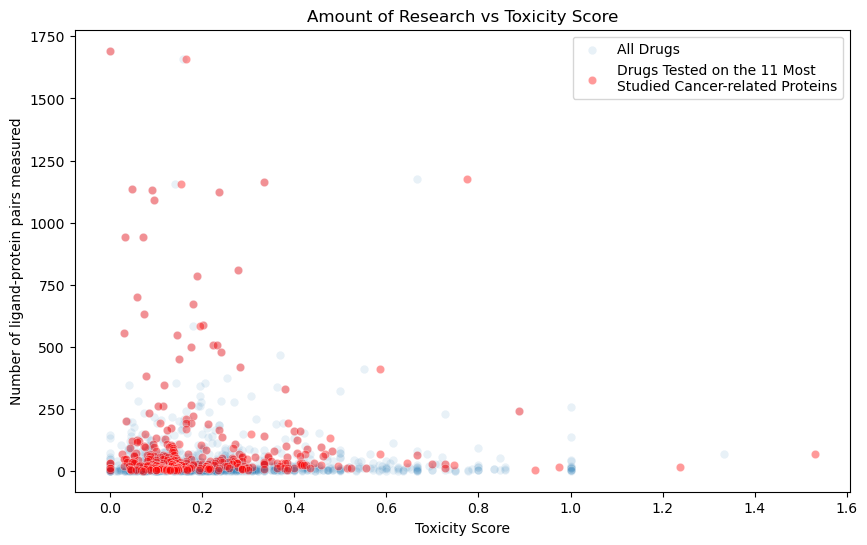

In [13]:
toxicity_analysis.plot_toxicity_vs_proteins()

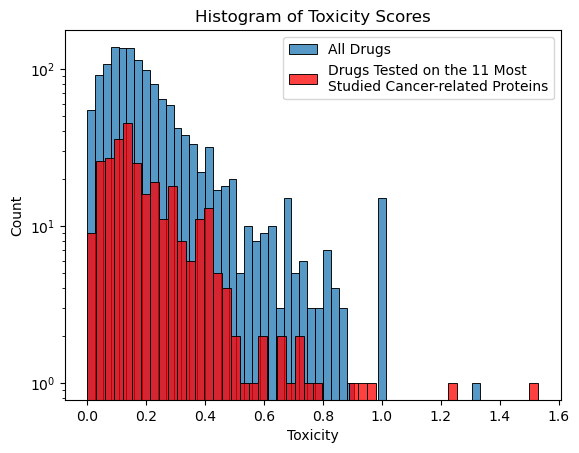

In [14]:
toxicity_analysis.plot_toxicity_scores()